<a href="https://colab.research.google.com/github/Isaackante/NLP-Quora-Insincere-Questions-Classification/blob/main/NlP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text  import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

In [10]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [11]:
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv
!kaggle competitions download -c quora-insincere-questions-classification -f test.csv
!kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv

 89% 49.0M/54.9M [00:01<00:00, 50.3MB/s]
100% 54.9M/54.9M [00:01<00:00, 47.0MB/s]
 63% 10.0M/15.8M [00:00<00:00, 40.3MB/s]
100% 15.8M/15.8M [00:00<00:00, 60.3MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 78.4MB/s]


In [12]:
train_fname = './train.csv.zip'
test_fname = './test.csv.zip'
sub_fname = './sample_submission.csv.zip'

In [13]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sub_fname)

In [14]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [15]:
raw_df.sample(10)

,qid,question_text,target
1188640,e8ee621b29c3c37aca68,What do you do in your life to please God?,0
682053,8593f6cdcfa5c2be0250,We subleased a business location that I now fi...,0
1185813,e862f6540a0067f3dedc,How does Tim Ferriss conduct self experiments?,0
1055544,ced821858768b8e22ec5,What problems have you experienced with Agile?,0
106162,14c9f7cf8684edbd33ce,What are the most important committees in US C...,0
127799,190272897ded5a0f0d9b,How do people make friends easily (see comment...,0
419714,5242902cdea0624cd487,What are the 42 sounds in the English language?,0
1197345,eaabe249398f3ce31e0e,Do you think fidget spinners are a waste of mo...,0
381816,4ad52734331831eabd64,What are some examples of fallacious articles?,0
842803,a52d98edf13de5dbbca5,What is it like to use a heated pool in the co...,0


In [16]:
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [17]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [18]:
sample_df = raw_df.sample(100000)

In [19]:
sample_df.target.value_counts(normalize = True)

0    0.93761
1    0.06239
Name: target, dtype: float64

## Prepare data for training
- Conver text to TF-IDF vectors(Term Frequency - Inverse Document Frequency)
- Convert vectors to Pytorch tensors
- Create Pytorch data loaders

### Convert to TF-IDF Vectorizer

In [20]:
def tokenize(text):
  return [stemmer.stem(token) for token in word_tokenize(text)]

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
english_stopwords = stopwords.words('english')

In [24]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = english_stopwords, max_features=1000)

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
word_tokenize('This is, something (new)?')

['This', 'is', ',', 'something', '(', 'new', ')', '?']

In [28]:
stemmer = SnowballStemmer(language = 'english')

In [29]:
sample_df.question_text

1127320      How do you upload the design to website hoster?
373304     Is it possible to get into MIT as an Asian-Ame...
873137            Has Donald Trump ever met Michael Jackson?
932469     Assuming the physical laws as we think they ar...
387744     How did you react the first time you saw a nak...
                                 ...                        
403459     Most experimental procedures and medications a...
902437     Where can I find out info on YouTube's new sub...
1081343                    Why is Malawi a peaceful country?
1288536                            What is your stand on EJ?
640292     Why are red, green and white the Christmas col...
Name: question_text, Length: 100000, dtype: object

In [30]:
%%time
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 28.8 s, sys: 99.6 ms, total: 28.9 s
Wall time: 31 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x780956fc0b80>)

In [31]:
vectorizer.get_feature_names_out()[:100]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '4', '5', '6', '7', '8', ':', '?', '[', ']', '``', 'abl',
       'abus', 'accept', 'accomplish', 'accord', 'account', 'achiev',
       'act', 'action', 'activ', 'actor', 'actual', 'ad', 'add',
       'address', 'admiss', 'adult', 'advanc', 'advantag', 'advic',
       'affect', 'african', 'age', 'ago', 'agre', 'air', 'allow', 'along',
       'alreadi', 'also', 'altern', 'alway', 'amazon', 'america',
       'american', 'among', 'amount', 'android', 'ani', 'anim', 'anoth',
       'answer', 'anxieti', 'anyon', 'anyth', 'apart', 'app', 'appear',
       'appl', 'appli', 'applic', 'arab', 'area', 'armi', 'around', 'art',
       'asian', 'ask', 'associ', 'atheist', 'attack', 'attract',
       'australia', 'avail', 'averag', 'avoid'], dtype=object)

## Transform the questions into vector

In [32]:
inputs = vectorizer.transform(sample_df.question_text)

In [33]:
inputs.shape

(100000, 1000)

In [34]:
targets = sample_df.target.values

In [35]:
targets.shape

(100000,)

In [36]:
%%time
test_input = vectorizer.transform(test_df.question_text)

CPU times: user 1min 42s, sys: 268 ms, total: 1min 42s
Wall time: 1min 43s


In [37]:
test_input.shape

(375806, 1000)

## Split training and validation set

In [38]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size = 0.3)

In [39]:
train_inputs.shape

(70000, 1000)

In [40]:
val_inputs.shape

(30000, 1000)

In [41]:
train_targets

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
val_targets

array([0, 0, 0, ..., 0, 0, 0])

## Convert to Pytorch tensors

In [43]:
train_tensors = F.normalize(torch.tensor(train_inputs.toarray()).float(), dim=0)
val_tensors = F.normalize(torch.tensor(val_inputs.toarray()).float(), dim=0)

In [44]:
train_tensors.shape

torch.Size([70000, 1000])

In [45]:
val_tensors.shape

torch.Size([30000, 1000])

In [47]:
train_ds = TensorDataset(train_tensors, torch.tensor(train_targets))
val_ds = TensorDataset(val_tensors, torch.tensor(val_targets))

In [48]:
test_input_tensors = torch.tensor(test_input.toarray()).float()

In [50]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [51]:
for inputs_batch, targets_batch in train_dl:
    print('inputs.shape', inputs_batch.shape)
    print('targets.shape', targets_batch.shape)
    print(targets_batch)
    break

inputs.shape torch.Size([128, 1000])
targets.shape torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


## Building deep learning model

In [52]:
class FeedForwardModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1000, 512)
    self.layer2 = nn.Linear(512,256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, 1)

  def forward(self, inputs):
    out = self.layer1(inputs)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    out = F.relu(out)
    out = self.layer4(out)
    return out

In [53]:
model = FeedForwardModel()

In [55]:
for batch in train_dl:

  bi, bt = batch
  print('inputs.shape', bi.shape)
  print('targets.shape', bt.shape)

  bo = model(bi)
  print('bo.shape', bo.shape)

  # Converts outputs to probabilities
  probs = torch.sigmoid(bo[:,0])
  print("probs", probs[:10])

  # Converts probs to prediction
  preds = (probs > 0.5).int()
  print('preds', preds[:10])
  print('targets', bt[:10])

  # Check metrics
  print('accuracy', accuracy_score(bt, preds))
  print('F1', f1_score(bt,preds))

  break

inputs.shape torch.Size([128, 1000])
targets.shape torch.Size([128])
bo.shape torch.Size([128, 1])
probs tensor([0.5137, 0.5136, 0.5136, 0.5136, 0.5136, 0.5136, 0.5136, 0.5136, 0.5136,
        0.5136], grad_fn=<SliceBackward0>)
preds tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
targets tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
accuracy 0.0859375
F1 0.15827338129496402


In [60]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)

        probs = torch.sigmoid(out[:,0])
        loss = F.binary_cross_entropy(probs, targets.float(), weight=torch.tensor(20.))
        losses.append(loss.item())

        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)

        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s)

In [63]:
evaluate(model, train_dl)

(14.346563438610795, 0.06202663880908854, 0.11598093160496405)

In [64]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs,
                                          targets.float(),
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [65]:
history = [evaluate(model, val_dl)]

In [66]:
history

[(14.345227347029017, 0.06328679078014184, 0.11828886707836005)]

In [67]:
history += fit(5, 0.01, model, train_dl, val_dl)

Epoch: 0; Loss: 3.1800; Accuracy: 0.9397; F1 Score: 0.4570
Epoch: 1; Loss: 3.4210; Accuracy: 0.9333; F1 Score: 0.4862
Epoch: 2; Loss: 3.3866; Accuracy: 0.9274; F1 Score: 0.4835
Epoch: 3; Loss: 3.3947; Accuracy: 0.9310; F1 Score: 0.4905
Epoch: 4; Loss: 3.9418; Accuracy: 0.9235; F1 Score: 0.4804


In [68]:
history += fit(5, 0.01, model, train_dl, val_dl)

Epoch: 0; Loss: 3.8100; Accuracy: 0.9306; F1 Score: 0.4803
Epoch: 1; Loss: 4.7672; Accuracy: 0.9292; F1 Score: 0.4675
Epoch: 2; Loss: 5.0989; Accuracy: 0.9278; F1 Score: 0.4690
Epoch: 3; Loss: 6.8034; Accuracy: 0.9325; F1 Score: 0.4633
Epoch: 4; Loss: 8.3296; Accuracy: 0.9322; F1 Score: 0.4317


In [69]:
history += fit(5, 0.01, model, train_dl, val_dl)

Epoch: 0; Loss: 6.8452; Accuracy: 0.9310; F1 Score: 0.4436
Epoch: 1; Loss: 9.5294; Accuracy: 0.9337; F1 Score: 0.4259
Epoch: 2; Loss: 10.7081; Accuracy: 0.9382; F1 Score: 0.4047
Epoch: 3; Loss: 11.3636; Accuracy: 0.9395; F1 Score: 0.3947
Epoch: 4; Loss: 15.3515; Accuracy: 0.9341; F1 Score: 0.4016


In [70]:
losses = [item[0] for item in history]

Text(0.5, 1.0, 'Loss')

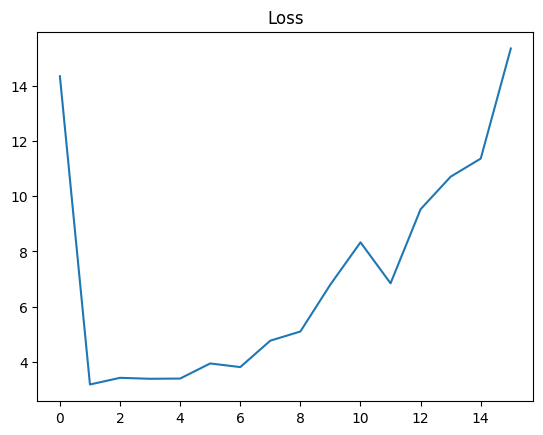

In [72]:
plt.plot(losses);
plt.title('Loss')

In [73]:
f1s = [item[2] for item in history]

Text(0.5, 1.0, 'F1 Score')

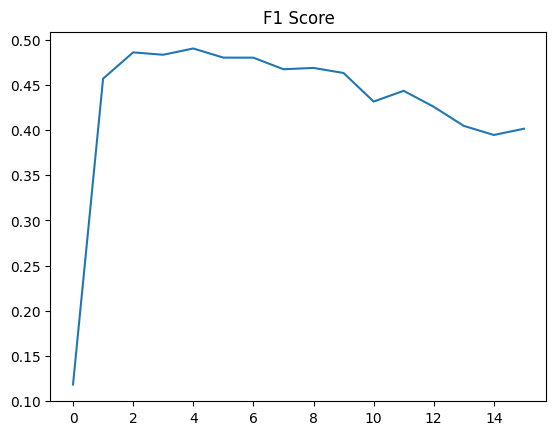

In [74]:
plt.plot(f1s)
plt.title('F1 Score')

## Make Predictions

In [76]:
test_tensors = torch.tensor(test_input.toarray()).float()

In [77]:
test_ds = TensorDataset(test_tensors)

In [78]:
test_dl = DataLoader(test_ds, batch_size)

In [122]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [129]:
test_preds = predict(model, test_dl)

In [130]:
test_preds[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [133]:
small_df = raw_df.sample(20)

In [134]:
def predict_df(df):
  inputs = vectorizer.transform(df.question_text)
  input_tensor = torch.tensor(inputs.toarray()).float()
  outputs = model(input_tensor)
  probs = torch.sigmoid(outputs[:,0])
  preds = (probs > 0.5).int()
  return preds

In [140]:
# small_df

In [136]:
small_df.target.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [137]:
predict_df(small_df)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       dtype=torch.int32)

In [138]:
small_df.question_text

1280430        What are the key result areas of bureaucrats?
375970                  What are all the properties of math?
788803                 How do you overcome social isolation?
563395               What are examples of pragmatist ethics?
196844     Was is behind the renewed interest in the Myer...
639854     Do animals (especially big cats) regard humans...
1118163    What is the best way to promote flight support...
1077297                   How can I group selected channels?
599031     What are some of the most recommended business...
1002713    Why do Muslims in India hate Narendra Modi wit...
929133     What are some popular dark and mysterious quotes?
1275033                When does a sea turtle find its food?
164438     What are the conflicts in the play "Antigone" ...
731122     Who can create the test plan in software testi...
673029       Do you think Jamie will kill Cersei at the end?
886802     Why is falsehood a misrepresentation of the tr...
498438     What should I

In [139]:
small_df.question_text.values

array(['What are the key result areas of bureaucrats?',
       'What are all the properties of math?',
       'How do you overcome social isolation?',
       'What are examples of pragmatist ethics?',
       'Was is behind the renewed interest in the Myers-Briggs personality test that is one of the hottest You Tube topics?',
       'Do animals (especially big cats) regard humans as prey or predator? If they were to attack a human, would it be to feed, or to elminate a competitor?',
       'What is the best way to promote flight support company?',
       'How can I group selected channels?',
       'What are some of the most recommended businesses that are easy to setup up online and are less costly but profitable?',
       'Why do Muslims in India hate Narendra Modi without any reason and support people like Zakir Naik or Afzal Guru?',
       'What are some popular dark and mysterious quotes?',
       'When does a sea turtle find its food?',
       'What are the conflicts in the play "